# Explore Random Forest Classification in A Highly Imbalanced Dataset (Health Care Provider Credentials)

**Project Motivation**: Practicing medicine without a rightful license is not only illegal but dangerous for patients. But among all the problematic license case reported, only a very small fraction of cases had legal action taken against them. It's unclear what are the determining factors.  

**The data**: The Washington State Department of Health presents this data on the credentials of health care providers from July 1998 to date. These records are considered certified by the Department of Health.

**Modeling strategy**: I used the Random Forest Model to predict legal action given the case details (FirstIssueDate, ExpirationDate, LastIssueDate, CredentialType, Status, BirthYear). 

**Technical Interests**: The dataset is highly imbalanced data, and it's unclear what type of strategy would work best. I explored two different methods using a random forest model, one method is to sample an equal number of data from both classes (Legal Action taken or not). The second method is to use a ScikitLearn built-in weight balance option: class_weight='balanced'.

**Technical Details**: The two features "CredentialType" & "Status" have too many categories, I manuelly reduced their categories by grouping together the similar ones. And I also introduced a new feature: the "Duration" of holding the license. When this feature replaces "FirstIssueDate" & "ExpirationDate", the model performed just as well. 

**Conclusion**: The most important feature is the FirstIssueDate of the license. This may imply that earlier cases are more likely to have legal action taken against them, as legal action probably takes a long time to process. The first method worked a lot better than the ScikitLearn built-in method. With the first method, we can capture about 70% of the subsampled data. 

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [310]:
# read the dataset & take an intial look at the data
cred = pd.read_csv('Health_Care_Provider_Credential_Data.csv')
cred.head()

,CredentialNumber,LastName,FirstName,MiddleName,CredentialType,Status,BirthYear,CEDueDate,FirstIssueDate,LastIssueDate,ExpirationDate,ActionTaken
0,HC60243358,Sangani,Vasanti,Vinud,Health Care Assistant Certification,SUPERSEDED,1969.0,NaN,20110927.0,20110927.0,20130927.0,No
1,D160054498,Summers,Kinda,Lee,Dental Assistant Registration,EXPIRED,1968.0,NaN,20081206.0,20161109.0,20171116.0,No
2,NA60113523,Singh,Wassan,NaN,Nursing Assistant Registration,EXPIRED,1984.0,NaN,20091008.0,20091008.0,20100826.0,No
3,RC60077317,Turner,India,Susanne,Counselor Registration,EXPIRED,1957.0,NaN,20090224.0,20090224.0,20100517.0,No
4,NA60052832,Castro,Brittany,Marie,Nursing Assistant Registration,EXPIRED,1990.0,NaN,20081110.0,20081110.0,20090413.0,No


In [312]:
# get information about the data
cred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1696124 entries, 0 to 1696123
Data columns (total 12 columns):
CredentialNumber    object
LastName            object
FirstName           object
MiddleName          object
CredentialType      object
Status              object
BirthYear           float64
CEDueDate           float64
FirstIssueDate      float64
LastIssueDate       float64
ExpirationDate      float64
ActionTaken         object
dtypes: float64(5), object(7)
memory usage: 155.3+ MB


### Preprocess the data

1. Dropping missing & irrelevant data
2. Do pairplot to observe any trend. <br>
    **Observation**: <br>
    a) Number of 'Yes' is only 1.22% of the data, thus the data is very imbalanced.<br>
    b) Even less number of 'Pending' is present in the data, thus this class is merged with the 'No' class.<br>
    c) 'FirstIssueDate','LastIssueDate', 'ExpirationDate' &  'BirthYear' are correlated, which may affect evaluation of their importance when using a Random Forest model. 
3. Replace non-numerical features with dummy columns. 
4. For features with too many dummy columns, reduce the number of columns by grouping. 


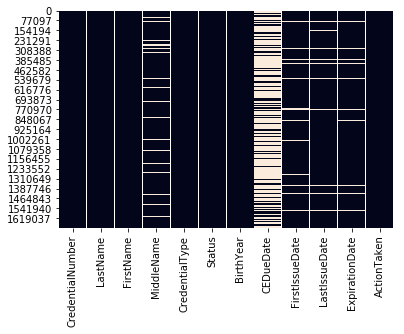

In [153]:
# check missing data
sns.heatmap(cred.isnull(),cbar=False)

In [191]:
# drop irrelevant features, and 'CEDueDate' which contains lots of NAN. 
cred.drop(['CredentialNumber','LastName','FirstName','MiddleName','CEDueDate'],axis=1,inplace=True)
cred.dropna(inplace=True)

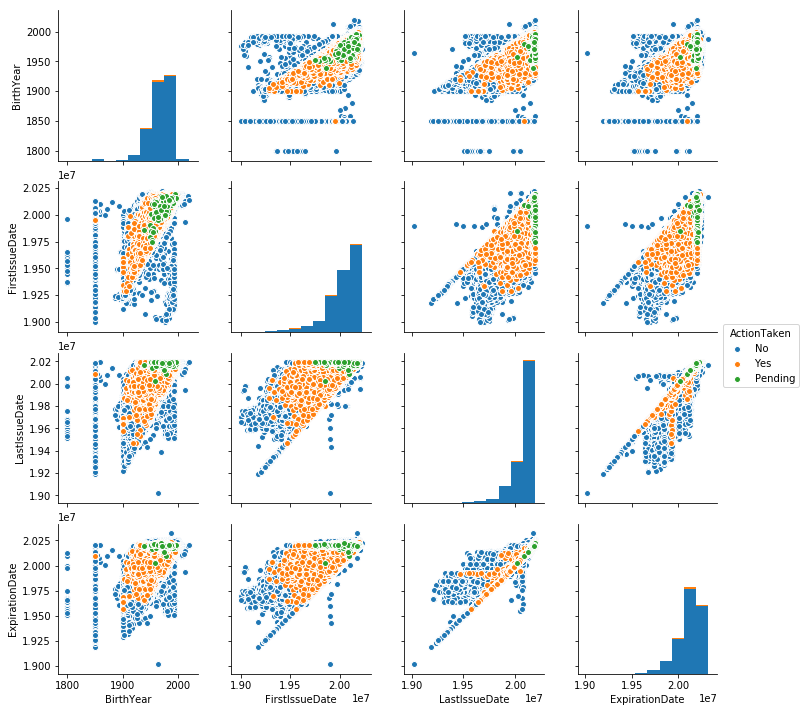

In [192]:
# do pairplot to look for any trends
sns.pairplot(cred, hue = 'ActionTaken')

In [302]:
# From the plot, observed that the amount of 'Yes' is much smaller, to quantify it: 
cred = pd.get_dummies(cred,columns=['ActionTaken'],drop_first=True) 
cred = cred.drop(['ActionTaken_Pending'],axis=1)
print('Only ' + str(sum(cred['ActionTaken_Yes']))+ ' \'Yes\' present among '+str(np.shape(cred)[0])+
      ' total training samples, this ammounts to '  + '%.2f' % (sum(cred['ActionTaken_Yes'])/np.shape(cred)[0]*100) +'%')

Only 19026 'Yes' present among 1557034 total training samples, this ammounts to 1.22%


Noticed that 'CredentialType','Status', 'ActionTaken' are useful information that aren't in numerical form. 
Need to convert them into numerical features with 'get_dummies'. 
But 'CredentialType' & 'Status' would be too many features.Thus worked on grouping features first. 

In [194]:
# create dummy data for 'Status' and 'CredentialType'
status= pd.get_dummies(cred['Status']) 
credtype = pd.get_dummies(cred['CredentialType']) 

In [195]:
print(status.columns)
# noticed several potential categories: 
ACTIVE = ['ACTIVE','RETIRED ACTIVE', 'APPROVED', 'MILITARY', 'RETIRED ACTIVE IN-STATE', 'RETIRED ACTIVE OUT-OF-STATE']
CONDITIONAL_ACTIVE=['ACTIVE NOT RENEWABLE', 'ACTIVE ON PROBATION','ACTIVE PROVISIONAL', 'ACTIVE WITH CONDITIONS','ACTIVE WITH RESTRICTIONS']
DENIED= ['DENIED LICENSURE', 'REVOKED','EXPIRED', 'SURRENDER', 'SUSPENDED', 'TERMINATED', 'VOLUNTARY SURRENDER', 'WITHDRAWN']
INACTIVE = ['INACTIVE','INACTIVE MILITARY RELATED', 'RETIRED', 'SUPERSEDED']
INOPERABLE = ['PENDING',  'SUMMARY LIMITATION', 'SUMMARY RESTRICTION', 'SUMMARY SUSPENSION','CLOSED']

Index(['ACTIVE', 'ACTIVE NOT RENEWABLE', 'ACTIVE ON PROBATION',
       'ACTIVE PROVISIONAL', 'ACTIVE WITH CONDITIONS',
       'ACTIVE WITH RESTRICTIONS', 'APPROVED', 'CLOSED', 'DENIED LICENSURE',
       'EXPIRED', 'INACTIVE', 'INACTIVE MILITARY RELATED', 'INOPERABLE',
       'MILITARY', 'PENDING', 'RETIRED', 'RETIRED ACTIVE',
       'RETIRED ACTIVE IN-STATE', 'RETIRED ACTIVE OUT-OF-STATE', 'REVOKED',
       'SUMMARY LIMITATION', 'SUMMARY RESTRICTION', 'SUMMARY SUSPENSION',
       'SUPERSEDED', 'SURRENDER', 'SUSPENDED', 'TERMINATED',
       'VOLUNTARY SURRENDER', 'WITHDRAWN'],
      dtype='object')


In [196]:
# replace all the sub-status with the name of each status category
cred['Status'].replace(ACTIVE,'ACTIVE', inplace = True)
cred['Status'].replace(CONDITIONAL_ACTIVE,'CONDITIONAL_ACTIVE', inplace = True)
cred['Status'].replace(DENIED,'DENIED', inplace = True)
cred['Status'].replace(INACTIVE,'INACTIVE', inplace = True)
cred['Status'].replace(INOPERABLE,'INOPERABLE', inplace = True)

In [314]:
[print(i) for i in credtype.columns]
NURSE =  []; DENTAL= []; EMS = []; VET = []; SPECIALIST = []
PSYCH = []; ADDICT = []; ADJUNCT=[]
for i in credtype.columns:
    if 'Nurse' in i:
        NURSE.append(i)
    elif any(s in i for s in ('Dental', 'Dentist','Denturist')):
        DENTAL.append(i)
    elif any(s in i for s in ('Emergency', 'EMS' ,'Intermediate' )):
        EMS.append(i)
    elif any(s in i for s in ('Animal','Veterinary')):
        VET.append(i)
    elif any(s in i for s in ('Airway', 'Athletic', 'Audiologist', 'Cardiovascular', 'Chiropractic' )):
        SPECIALIST.append(i)
    elif any(s in i for s in ('Counselor', 'Behavior', 'Therapist', 'Psychologist')):
        PSYCH.append(i)
    elif any(s in i for s in ('Drug', 'Marijuana', 'Substance')):
        ADDICT.append(i)
    elif any(s in i for s in ('Assistant','Medical Program', 'Paramedic','Social Worker')):
        ADJUNCT.append(i)
    else:
        SPECIALIST.append(i)

Acupuncturist or Acupuncture and Eastern Medicine Practitioner License
Acupuncturist or Acupuncture and Eastern Medicine Practitioner Temp Permit
Advanced Emergency Medical Technician Certification
Advanced Registered Nurse Practitioner Anesthetist License
Advanced Registered Nurse Practitioner Clinical Specialist License
Advanced Registered Nurse Practitioner Community Health License
Advanced Registered Nurse Practitioner Enterostomal Therapy License
Advanced Registered Nurse Practitioner License
Advanced Registered Nurse Practitioner Maternal Gynecological Neonatal License
Advanced Registered Nurse Practitioner Medical Surgical
Advanced Registered Nurse Practitioner Midwife License
Advanced Registered Nurse Practitioner Neurosurgical License
Advanced Registered Nurse Practitioner Occupational Health License
Advanced Registered Nurse Practitioner School License
Advanced Registered Nurse Practitioner Temporary Practice Permit
Animal Massage Certification for Large Animals
Animal Massag

In [198]:
# replace all the sub-status with the name of each status category
cred['CredentialType'].replace(NURSE,'NURSE', inplace = True)
cred['CredentialType'].replace(DENTAL,'DENTAL', inplace = True)
cred['CredentialType'].replace(EMS,'EMS', inplace = True)
cred['CredentialType'].replace(VET,'VET', inplace = True)
cred['CredentialType'].replace(SPECIALIST,'SPECIALIST', inplace = True)
cred['CredentialType'].replace(PSYCH,'PSYCH', inplace = True)
cred['CredentialType'].replace(ADDICT,'ADDICT', inplace = True)
cred['CredentialType'].replace(ADJUNCT,'ADJUNCT', inplace = True)


In [199]:
cred = pd.get_dummies(cred,columns=['CredentialType', 'Status'],drop_first=True) 

In [200]:
cred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1557034 entries, 0 to 1696123
Data columns (total 17 columns):
BirthYear                    1557034 non-null float64
FirstIssueDate               1557034 non-null float64
LastIssueDate                1557034 non-null float64
ExpirationDate               1557034 non-null float64
ActionTaken_Pending          1557034 non-null uint8
ActionTaken_Yes              1557034 non-null uint8
CredentialType_ADJUNCT       1557034 non-null uint8
CredentialType_DENTAL        1557034 non-null uint8
CredentialType_EMS           1557034 non-null uint8
CredentialType_NURSE         1557034 non-null uint8
CredentialType_PSYCH         1557034 non-null uint8
CredentialType_SPECIALIST    1557034 non-null uint8
CredentialType_VET           1557034 non-null uint8
Status_CONDITIONAL_ACTIVE    1557034 non-null uint8
Status_DENIED                1557034 non-null uint8
Status_INACTIVE              1557034 non-null uint8
Status_INOPERABLE            1557034 non-null u

# Imbalanced data

The data is super imbalanced with very few 'Yes'. 
To work around the imbalance, I'm trying two different strategies with Random Forest Mode:
1. Take an equal sample of Yes & No. 
2. Use sklearn built in class_weight='balanced'.

### Method 1
**Observation**: with around 70% precision and recall for each category, the model worked fine.<br>

### Method 2
**Observation**: This method really didn't work well for the 'yes' category, with only 0.01 recall, potentially because the 'Yes' present in the  training data is only 1.18%. 

**Conclusion**: Method 1 works better than Method 2. <br>
**Interpretation**: Based on Method 1, the 'FirstIssueDate' seem to predict legal action the best, followed by 'ExpirationDate' and 'LastIssueDate'. <br> 
One interpretation is that cases  with an earlier issued license are more likely to be processed, perhaps simply because they have been reported earlier. <br>

**Next Step**
'ExpirationDate' and 'LastIssueDate' and may correlate with "FirstIssueDate", and are predictive for the same reason. However, the duration of the license could be another factor. Thus for the next attempt, **I replaced 'FirstIssueDate' and 'ExpirationDate' with the derived feature 'Duration'. **

## Method 1: Take equal sample of Yes & No.

In [303]:
# method 1: Take equal sample of Yes & No.
subcredyes = cred[cred['ActionTaken_Yes']==1]
subcred1 = pd.concat([subcredyes,cred[cred['ActionTaken_Yes']==0].sample(n=np.shape(subcredyes)[0],random_state=81)])

In [292]:
from sklearn.model_selection import train_test_split
X1 = subcred1.drop(['ActionTaken_Yes'],axis=1)
y1 = subcred1['ActionTaken_Yes']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.30,random_state=81)

In [203]:
from sklearn.ensemble import RandomForestClassifier
rfc1 = RandomForestClassifier(n_estimators=200)
rfc1.fit(X_train1, y_train1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [204]:
rfc1_pred = rfc1.predict(X_test1)

In [205]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test1,rfc1_pred))
print(classification_report(y_test1,rfc1_pred))

[[3885 1755]
 [1594 4182]]
             precision    recall  f1-score   support

          0       0.71      0.69      0.70      5640
          1       0.70      0.72      0.71      5776

avg / total       0.71      0.71      0.71     11416



In [206]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfc1.feature_importances_), X_train1.columns), 
             reverse=True))


Features sorted by their score:
[(0.293, 'FirstIssueDate'), (0.2227, 'ExpirationDate'), (0.2181, 'LastIssueDate'), (0.182, 'BirthYear'), (0.0174, 'Status_CONDITIONAL_ACTIVE'), (0.0162, 'CredentialType_ADJUNCT'), (0.011, 'CredentialType_NURSE'), (0.0083, 'Status_DENIED'), (0.0073, 'CredentialType_SPECIALIST'), (0.0062, 'CredentialType_PSYCH'), (0.0048, 'CredentialType_EMS'), (0.0047, 'CredentialType_DENTAL'), (0.0039, 'Status_INACTIVE'), (0.0025, 'CredentialType_VET'), (0.0017, 'Status_INOPERABLE')]


## Method 2: Use sklearn's built-in tool: class_weight='balanced'.


In [293]:
# repeat the process using class_weight='balanced'
subcred = cred.sample(frac=0.05,random_state=81)
X = subcred.drop(['ActionTaken_Yes'],axis=1)
y = subcred['ActionTaken_Yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=81)
rfc = RandomForestClassifier(n_estimators=200,class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [294]:
print('Only ' + str(sum(y_train))+ ' \'Yes\' present among '+str(np.shape(y_train)[0])+
      ' total training samples, this ammounts to '  + '%.2f' % (sum(y_train)/np.shape(y_train)[0]*100) +'%')
print('Only ' + str(sum(y_test))+ ' \'Yes\' present among '+str(np.shape(y_test)[0])+
      ' total testing samples, this ammounts to '  +  '%.2f' % (sum(y_test)/np.shape(y_test)[0]*100) +'%')
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), X_train.columns), 
             reverse=True))

Only 645 'Yes' present among 54496 total training samples, this ammounts to 1.18%
Only 306 'Yes' present among 23356 total testing samples, this ammounts to 1.31%
[[23050     0]
 [  302     4]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     23050
          1       1.00      0.01      0.03       306

avg / total       0.99      0.99      0.98     23356

Features sorted by their score:
[(0.2894, 'FirstIssueDate'), (0.2059, 'ExpirationDate'), (0.2058, 'LastIssueDate'), (0.196, 'BirthYear'), (0.0188, 'Status_CONDITIONAL_ACTIVE'), (0.0162, 'CredentialType_ADJUNCT'), (0.0142, 'CredentialType_NURSE'), (0.0111, 'CredentialType_SPECIALIST'), (0.0106, 'Status_DENIED'), (0.0103, 'CredentialType_PSYCH'), (0.0066, 'CredentialType_DENTAL'), (0.0055, 'CredentialType_EMS'), (0.0049, 'Status_INACTIVE'), (0.0028, 'CredentialType_VET'), (0.002, 'Status_INOPERABLE'), (0.0, 'ActionTaken_Pending')]


## Derived Feature 'Duration'

**Observation**: Replacing 'ExpirationDate', 'FirstIssueDate' with their difference -'Duration' - worked almost as well as method 1. 

**Interpretation**: The features are quite correlated, but nevertheless support the idea that older cases are more likely to have undertaken legal actions. <br>

In [318]:
# Convert 'ExpirationDate', 'FirstIssueDate' to datetime format, to calculate the 'Duration' that a health care provider holds a license.
Duration =  pd.to_datetime(subcred1['ExpirationDate'], format='%Y%m%d.0') - pd.to_datetime(subcred1['FirstIssueDate'], format='%Y%m%d.0')
Duration = Duration.dt.days
X2 = subcred1.drop(['ActionTaken_Yes','ExpirationDate','FirstIssueDate'],axis=1)
X2['Duration'] = Duration
y2 = subcred1['ActionTaken_Yes']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.30,random_state=81)

In [319]:
rfc2 = RandomForestClassifier(n_estimators=200)
rfc2.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [320]:
rfc2_pred = rfc2.predict(X_test2)
print(confusion_matrix(y_test2,rfc2_pred))
print(classification_report(y_test2,rfc2_pred))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfc2.feature_importances_), X_train2.columns), 
             reverse=True))

[[3885 1755]
 [1704 4072]]
             precision    recall  f1-score   support

          0       0.70      0.69      0.69      5640
          1       0.70      0.70      0.70      5776

avg / total       0.70      0.70      0.70     11416

Features sorted by their score:
[(0.3731, 'Duration'), (0.3233, 'LastIssueDate'), (0.2119, 'BirthYear'), (0.0171, 'Status_DENIED'), (0.0171, 'Status_CONDITIONAL_ACTIVE'), (0.0148, 'CredentialType_ADJUNCT'), (0.01, 'CredentialType_NURSE'), (0.0072, 'CredentialType_SPECIALIST'), (0.0064, 'CredentialType_PSYCH'), (0.0055, 'CredentialType_EMS'), (0.0045, 'CredentialType_DENTAL'), (0.004, 'Status_INACTIVE'), (0.0026, 'CredentialType_VET'), (0.0022, 'Status_INOPERABLE')]
